# From Network (NetworkX) to Persistent Homology (PH) 
## Bottleneck distance:
##### "<i>To exploit the topological information and topological features inferred from persistent homology, one needs to be able to compare persistence diagrams.</i>"
This notebook expands what is taught in GUDHI Tutorial: https://github.com/GUDHI/TDA-tutorial (part 1 and 2), adding networks.<br>
The main focus is to compare de Persistent Homology distance between similar networks

In [1]:
import numpy as np
import pandas as pd
import gudhi as gd  
import matplotlib.pyplot as plt
from sklearn import manifold
import networkx as nx
from IPython.display import display
import seaborn as sns

### Create one original Dodecahedral Network and 5 variations. Then two Circular Ladder Graph

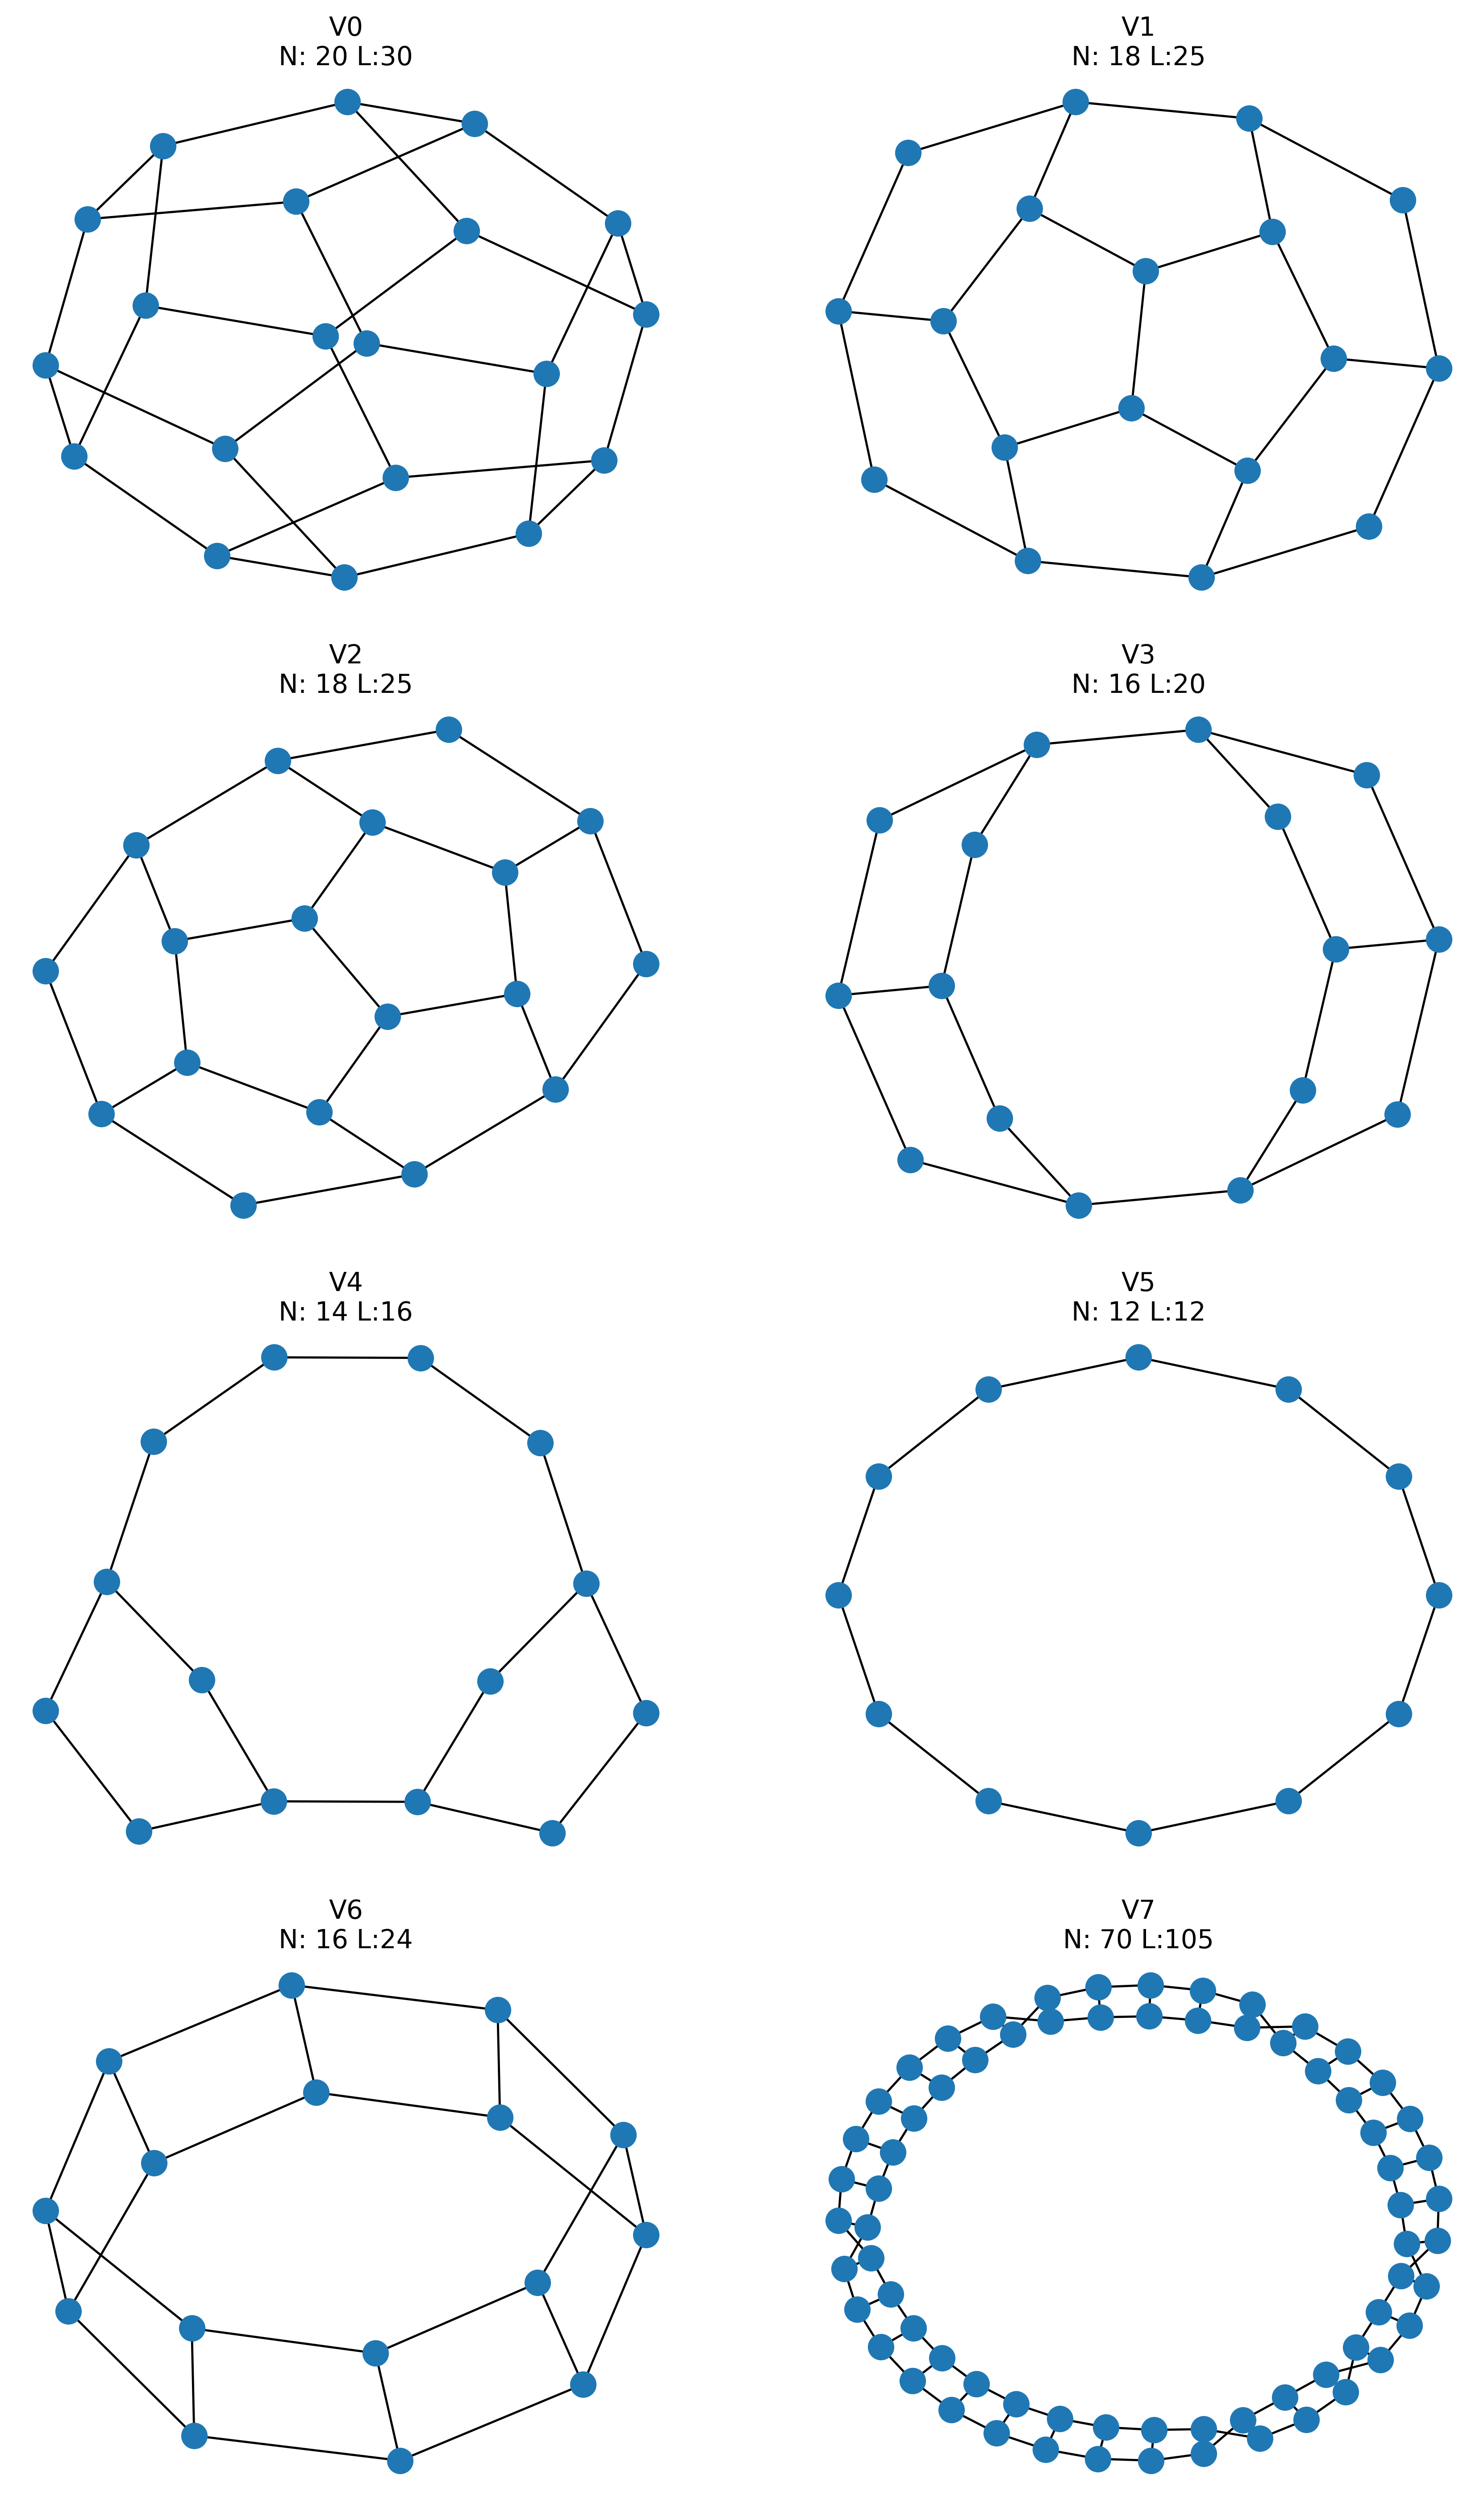

In [2]:
G_original = nx.generators.dodecahedral_graph()
G_original.name='V0'

G_v1 = nx.Graph(G_original)
G_v1.remove_nodes_from([0,1])
G_v1.name='V1'

G_v2 = nx.Graph(G_original)
G_v2.remove_nodes_from([15,16])
G_v2.name='V2'

G_v3 = nx.Graph(G_original)
G_v3.remove_nodes_from([0,1,15,16])
G_v3.name='V3'

G_v4 = nx.Graph(G_original)
G_v4.remove_nodes_from([0,1,15,16,14,5])
G_v4.name='V4'

G_v5 = nx.Graph(G_original)
G_v5.remove_nodes_from([0,1,15,16,14,5,10,19])
G_v5.name='V5'

G_v6 = nx.circular_ladder_graph(8)
G_v6.name='V6'

G_v7 = nx.circular_ladder_graph(35)
G_v7.name='V7'

#Plotting
plt.figure(figsize=(12,20),dpi=350)

for i,G in enumerate([G_original,G_v1,G_v2,G_v3,G_v4,G_v5,G_v6,G_v7]):
    plt.subplot(4,2,i+1)
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G,pos=pos,with_labels=False,node_size=125)
    plt.title(G.name+'\nN: '+str(G.number_of_nodes())+' L:'+str(G.number_of_edges()))

#plt.savefig('./imgs/BottleNeckDistance_NetworksUsed.png',dpi=500)
plt.show()

### Calculate the Distance Matrix for these networks

In [3]:
%%time
networks={}
distanceMatrixs={}
for G in [G_original,G_v1,G_v2,G_v3,G_v4,G_v5,G_v6,G_v7]:
    distanceMatrixs[G.name]=pd.DataFrame(dict(nx.shortest_path_length(G))).sort_index()
    networks[G.name]=G

Wall time: 108 ms


### Simplicial Complex using Vietoris–Rips complex - and - Persistance Homology with bar codes plot

usetex mode requires TeX.


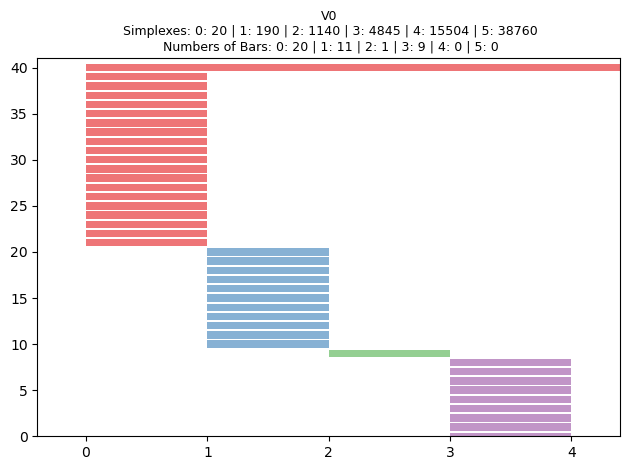

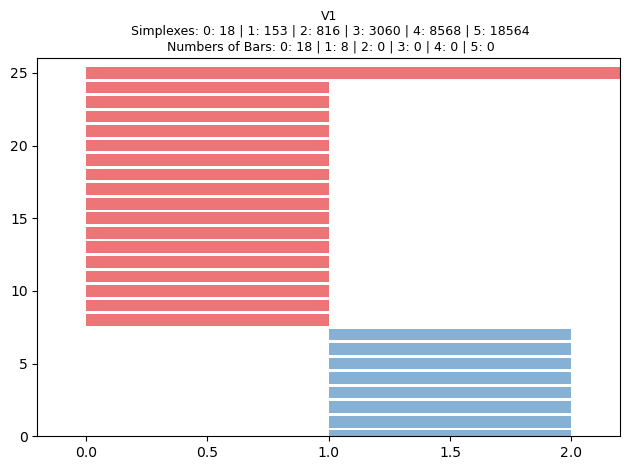

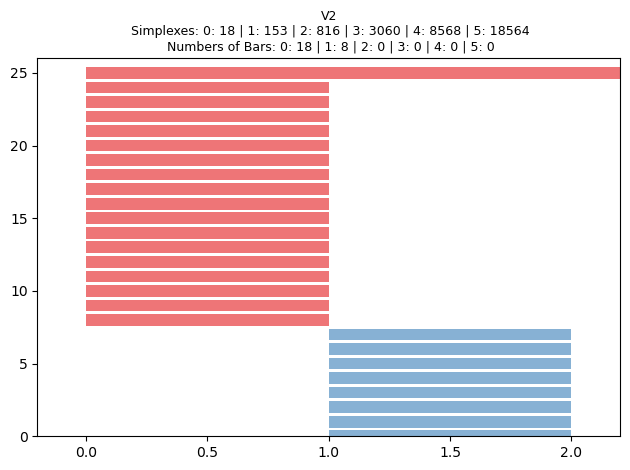

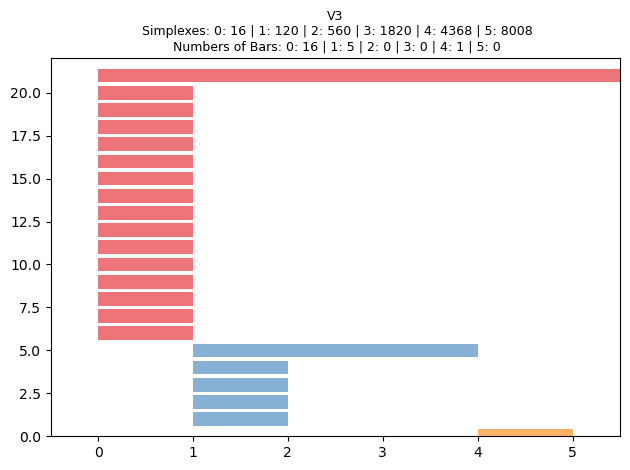

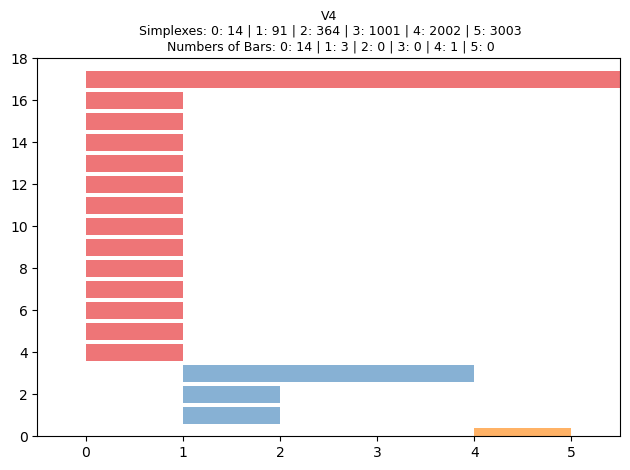

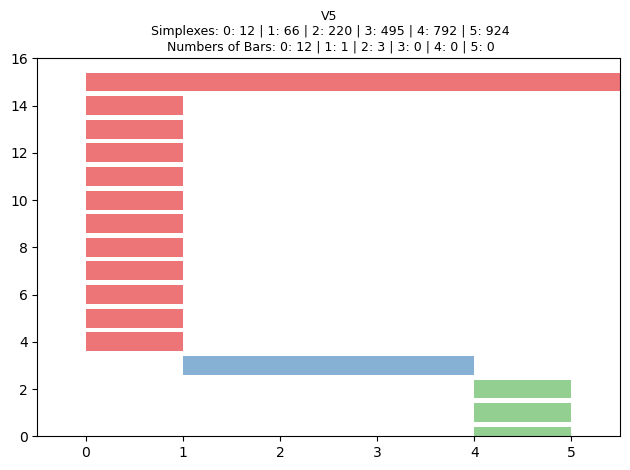

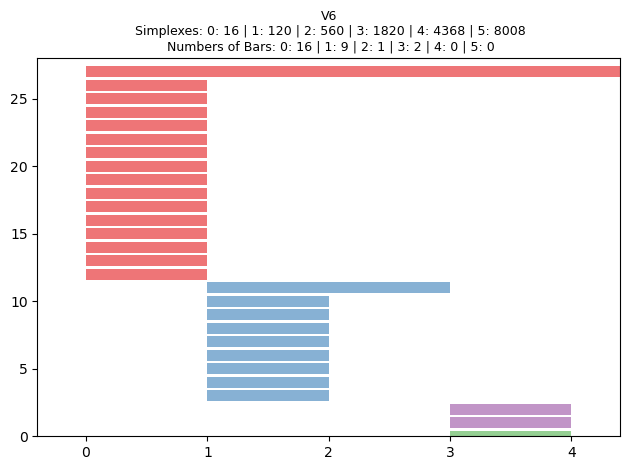

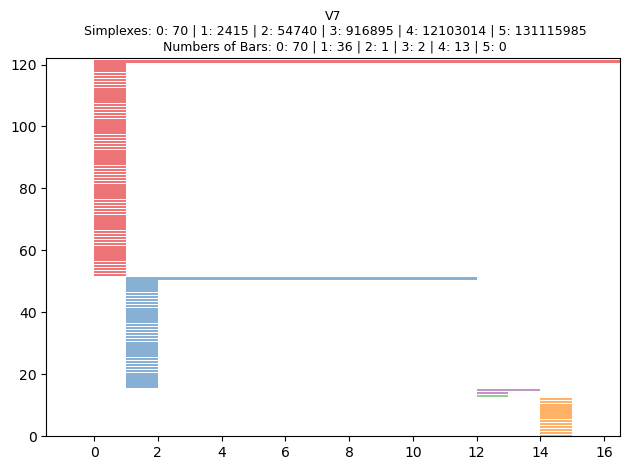

Wall time: 12min 37s


In [4]:
%%time
dim=5
simplexTrees={}
barCodes={}

for i,G in enumerate([G_original,G_v1,G_v2,G_v3,G_v4,G_v5,G_v6,G_v7]):
    skeleton = gd.RipsComplex(
        distance_matrix = distanceMatrixs[G.name].values
    ) 

    Rips_simplex_tree = skeleton.create_simplex_tree(max_dimension = dim)
    simplexTrees[G.name]=Rips_simplex_tree
    
    BarCode = Rips_simplex_tree.persistence()
    barCodes[G.name]=BarCode

    gd.plot_persistence_barcode(BarCode);    
    
    #----Simplexes Resume
    simplexesLen={}
    for simplex,filtration in Rips_simplex_tree.get_filtration():
        if(len(simplex)-1 not in simplexesLen):
            simplexesLen[len(simplex)-1]=1
        else:
            simplexesLen[len(simplex)-1]+=1    

    simplexesResume=''
    for item in simplexesLen.items():
        simplexesResume+=str(item[0])+': '+str(item[1])+' | '
    simplexesResume[0:-3]  
    
    #----Barcode Resume
    
    dimensionsLen={}
    for dim in range(0,dim+1):
        dimensionsLen[dim]=len([bd for bd in BarCode if (bd[0]==dim)])

    dimensionResume=''
    for item in dimensionsLen.items():
        dimensionResume+=str(item[0])+': '+str(item[1])+' | '
    dimensionResume[0:-3]    
            
    #--Plot
    
    plt.title(G.name+'\n Simplexes: '+simplexesResume[0:-3]+'\n Numbers of Bars: '+dimensionResume[0:-3],fontsize=9)
    plt.tight_layout()
    #plt.savefig('./imgs/PH - '+G.name+' - Rips',dpi=500)
    plt.show()

### Calculating Distances

In [5]:
%%time
resume={}
for dim in [0,1,2,3,4,5]:
    resume[dim]={}
    for nameA in simplexTrees:
        resume[dim][nameA]={}
        intervalA=simplexTrees[nameA].persistence_intervals_in_dimension(dim)
        for nameB in simplexTrees:
            intervalB=simplexTrees[nameB].persistence_intervals_in_dimension(dim)
            resume[dim][nameA][nameB]=round(gd.bottleneck_distance(intervalA,intervalB),3)

Wall time: 1.02 s


#### Displaying as table

In [6]:
for dim in resume:
    resume[dim]=pd.DataFrame(resume[dim])
    print("Dimension:",dim)
    display(resume[dim])

Dimension: 0


,V0,V1,V2,V3,V4,V5,V6,V7
V0,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5
V1,0.5,0.0,0.0,0.5,0.5,0.5,0.5,0.5
V2,0.5,0.0,0.0,0.5,0.5,0.5,0.5,0.5
V3,0.5,0.5,0.5,0.0,0.5,0.5,0.0,0.5
V4,0.5,0.5,0.5,0.5,0.0,0.5,0.5,0.5
V5,0.5,0.5,0.5,0.5,0.5,0.0,0.5,0.5
V6,0.5,0.5,0.5,0.0,0.5,0.5,0.0,0.5
V7,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0


Dimension: 1


,V0,V1,V2,V3,V4,V5,V6,V7
V0,0.0,0.5,0.5,1.5,1.5,1.5,1.0,5.5
V1,0.5,0.0,0.0,1.5,1.5,1.5,1.0,5.5
V2,0.5,0.0,0.0,1.5,1.5,1.5,1.0,5.5
V3,1.5,1.5,1.5,0.0,0.5,0.5,1.0,5.5
V4,1.5,1.5,1.5,0.5,0.0,0.5,1.0,5.5
V5,1.5,1.5,1.5,0.5,0.5,0.0,1.0,5.5
V6,1.0,1.0,1.0,1.0,1.0,1.0,0.0,5.5
V7,5.5,5.5,5.5,5.5,5.5,5.5,5.5,0.0


Dimension: 2


,V0,V1,V2,V3,V4,V5,V6,V7
V0,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5
V1,0.5,0.0,0.0,0.0,0.0,0.5,0.5,0.5
V2,0.5,0.0,0.0,0.0,0.0,0.5,0.5,0.5
V3,0.5,0.0,0.0,0.0,0.0,0.5,0.5,0.5
V4,0.5,0.0,0.0,0.0,0.0,0.5,0.5,0.5
V5,0.5,0.5,0.5,0.5,0.5,0.0,0.5,0.5
V6,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.5
V7,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0


Dimension: 3


,V0,V1,V2,V3,V4,V5,V6,V7
V0,0.0,0.5,0.5,0.5,0.5,0.5,0.5,1.0
V1,0.5,0.0,0.0,0.0,0.0,0.0,0.5,1.0
V2,0.5,0.0,0.0,0.0,0.0,0.0,0.5,1.0
V3,0.5,0.0,0.0,0.0,0.0,0.0,0.5,1.0
V4,0.5,0.0,0.0,0.0,0.0,0.0,0.5,1.0
V5,0.5,0.0,0.0,0.0,0.0,0.0,0.5,1.0
V6,0.5,0.5,0.5,0.5,0.5,0.5,0.0,1.0
V7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


Dimension: 4


,V0,V1,V2,V3,V4,V5,V6,V7
V0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.5
V1,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.5
V2,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.5
V3,0.5,0.5,0.5,0.0,0.0,0.5,0.5,0.5
V4,0.5,0.5,0.5,0.0,0.0,0.5,0.5,0.5
V5,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.5
V6,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.5
V7,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0


Dimension: 5


,V0,V1,V2,V3,V4,V5,V6,V7
V0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Displaying as heatmap

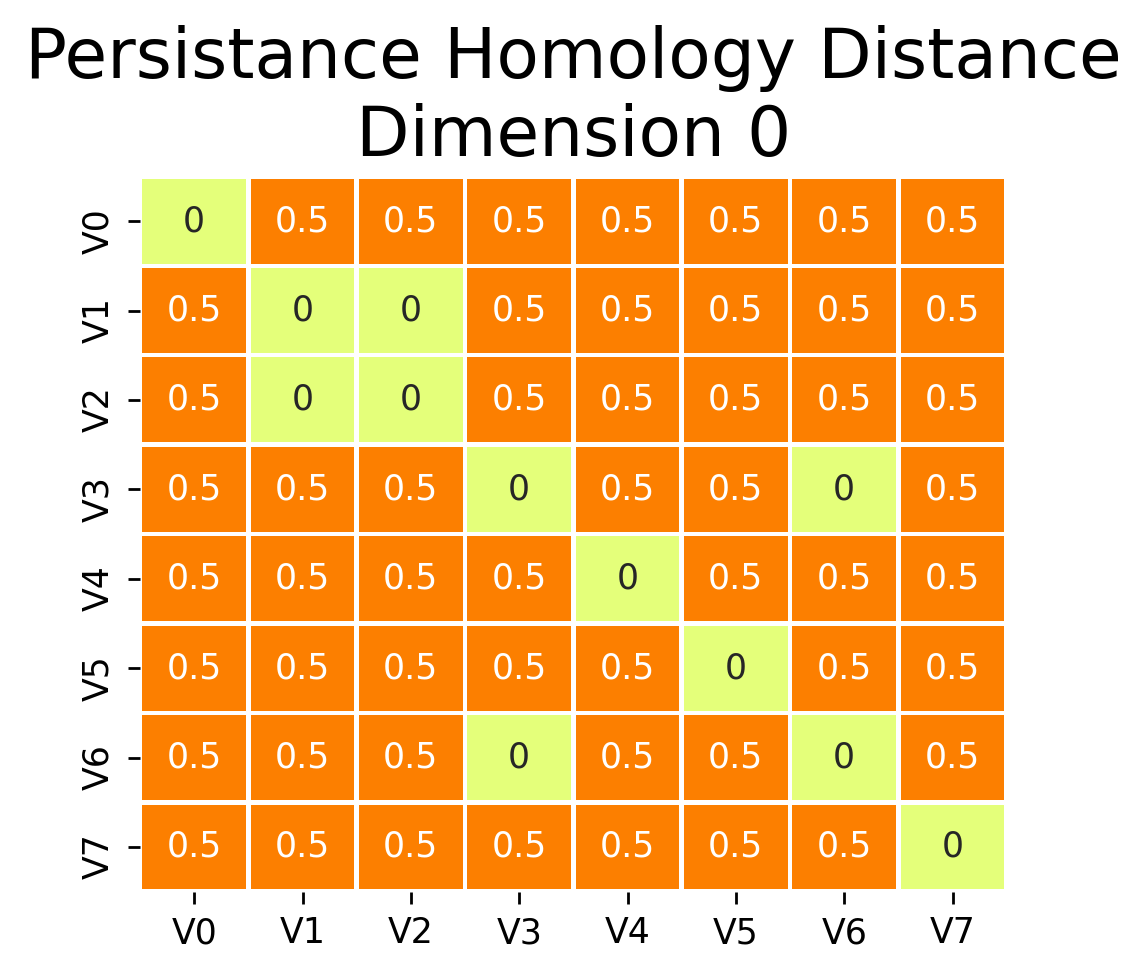

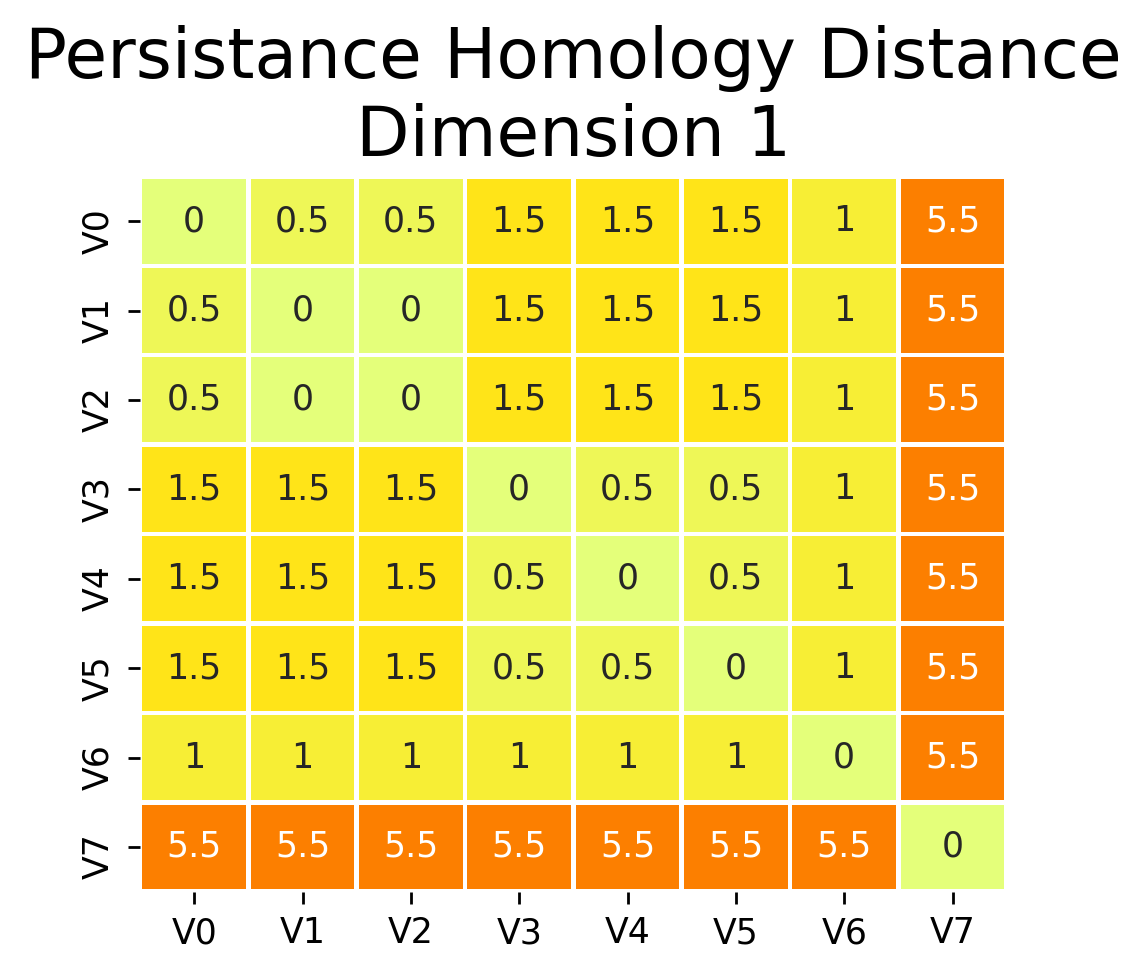

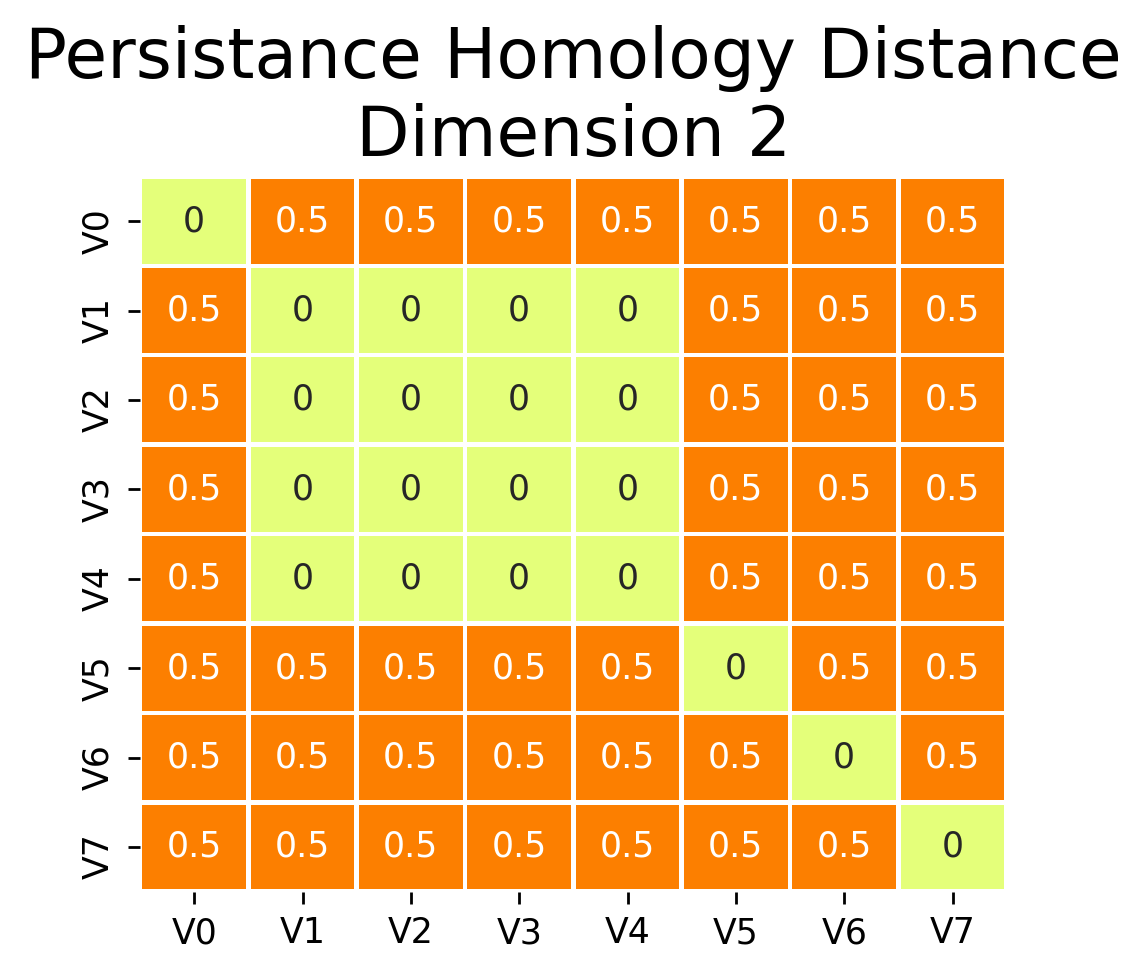

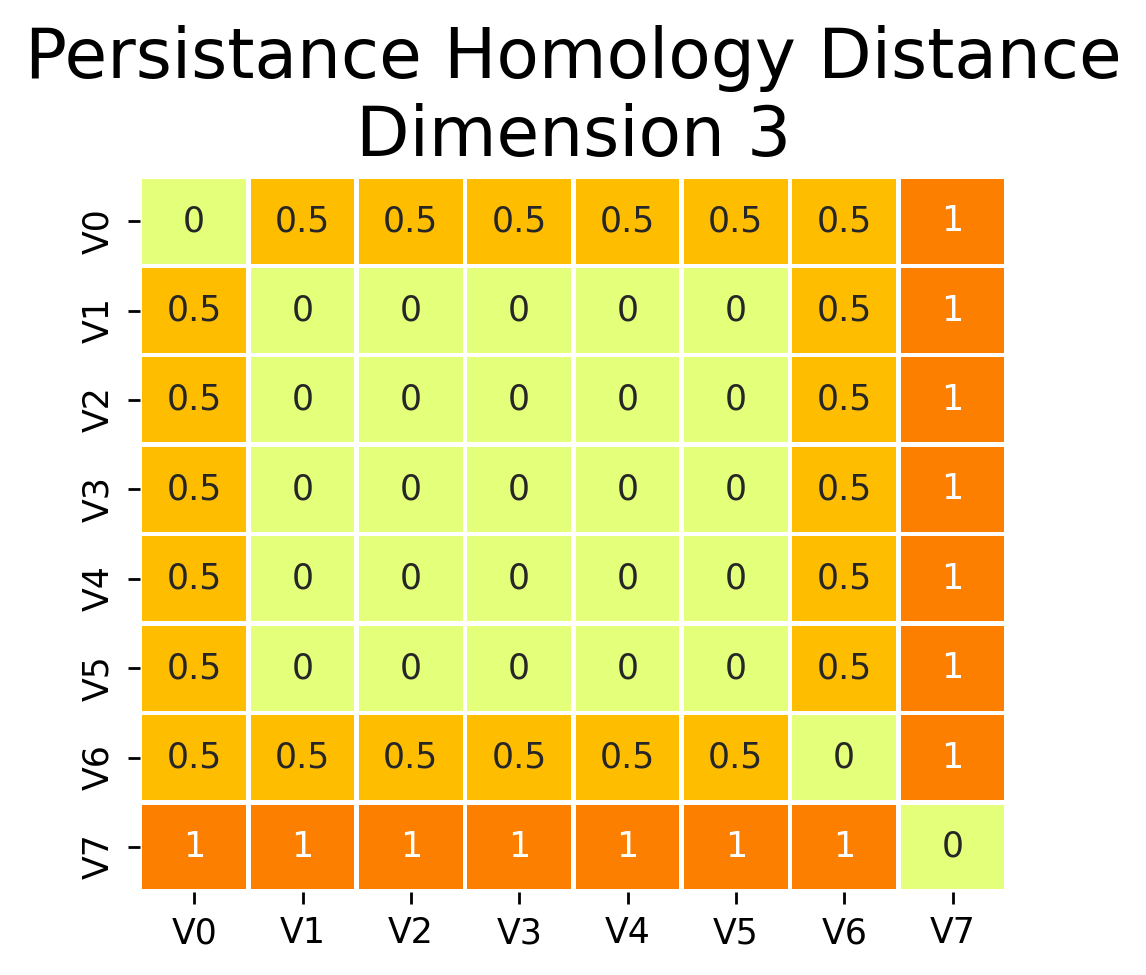

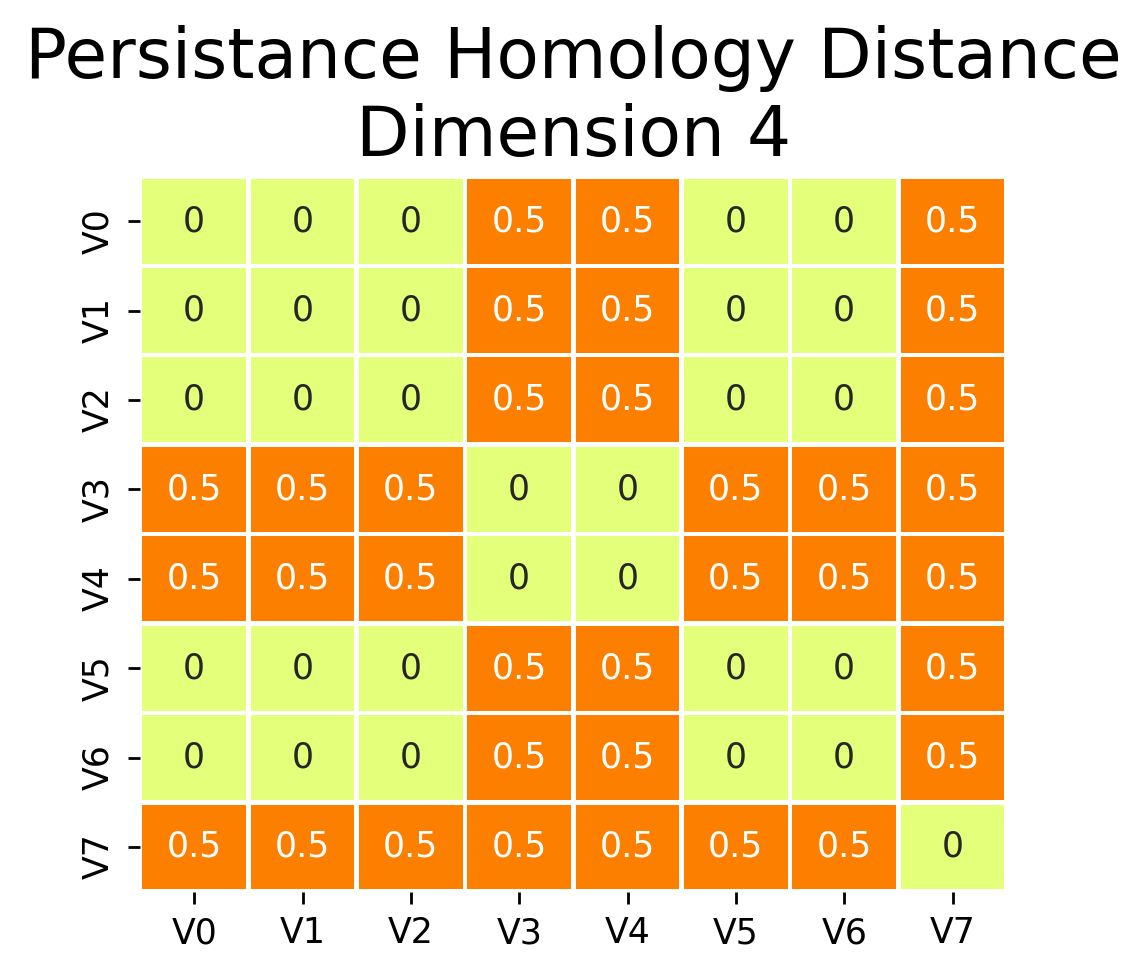

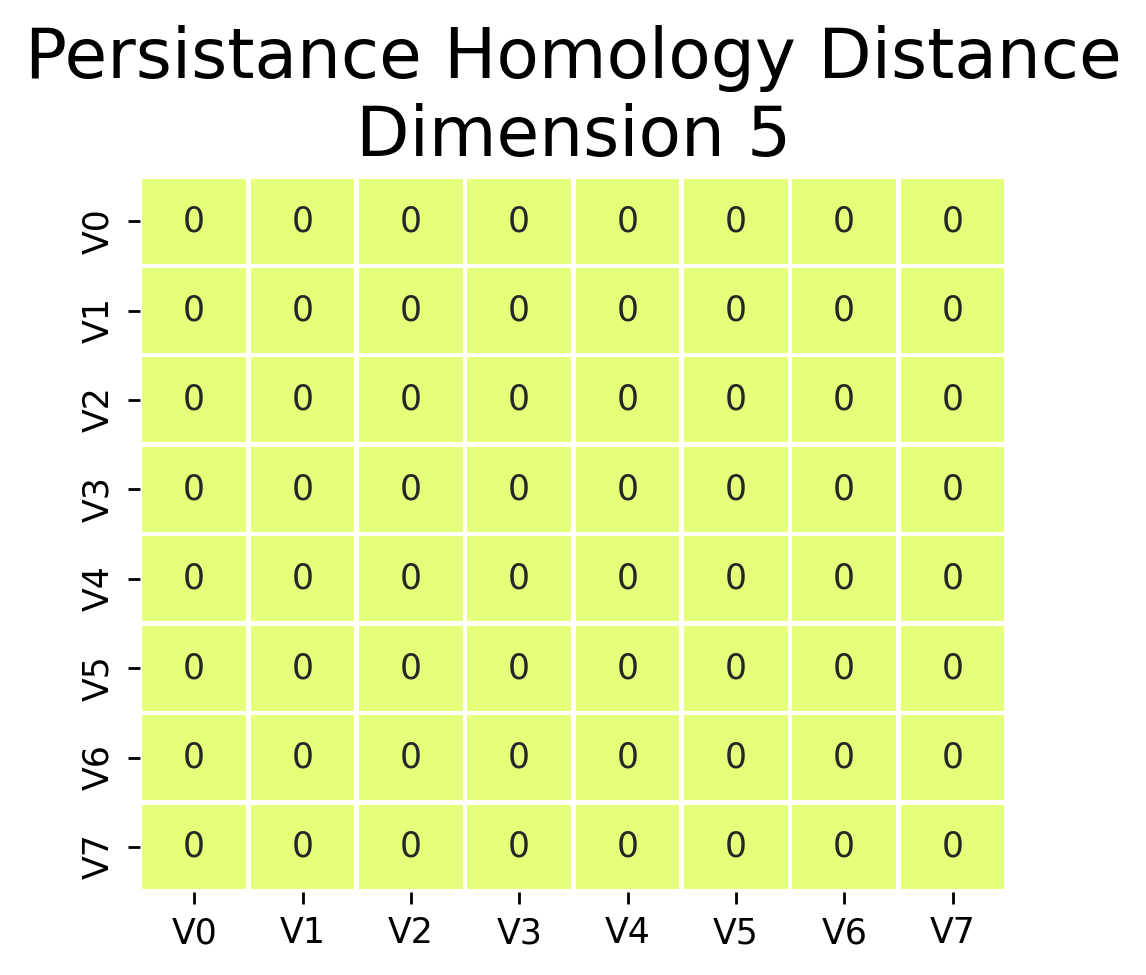

In [7]:
for dim in resume:
    plt.figure(figsize=(4,4),dpi=250)
    plt.title('Persistance Homology Distance\nDimension '+str(dim),fontsize=20)
    sns.heatmap(resume[dim], annot=True, fmt="g", cmap='Wistia',cbar=False,linewidths=1)
    plt.tight_layout()
    plt.show()